# 本章摘要

## 本章内容

- 理解卷积神经网络
- 使用数据增强来降低过拟合
- 使用预训练的卷积神经网络进行特征提取
- 微调预训练的卷积神经网络

# 卷积神经网络入门

## 实例化一个小型卷积神经网络

它是Conv2D层和MaxPooling2D层的堆叠。

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

2024-09-05 14:18:45.683996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-09-05 14:18:48.328479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


卷积神经网络接收的输入张量的形状为`(image_height, image_width, image_channels)`（不包括批量维度）。

In [2]:
# 查看卷积神经网络的架构
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

### 在MNIST图像上训练卷积神经网络

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
# 编译模型
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# 训练模型
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 12s 13ms/step - loss: 0.1578 - accuracy: 0.9506
Epoch 2/5
938/938 [==============================] - 12s 12ms/step - loss: 0.0455 - accuracy: 0.9862
Epoch 3/5
938/938 [==============================] - 12s 12ms/step - loss: 0.0314 - accuracy: 0.9900
Epoch 4/5
938/938 [==============================] - 12s 12ms/step - loss: 0.0235 - accuracy: 0.9929
Epoch 5/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0191 - accuracy: 0.9942


### 评估卷积神经网络

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0302 - accuracy: 0.9901
Test accuracy: 0.990


## 卷积运算

### Dense层与卷积层的区别

Dense层与卷积层的根本区别在于，Dense层从输入特征空间中学到的是全局模式（比如对于MNIST数字，全局模式就是涉及所有像素的模式），而卷积层学到的是局部模式（对于图像来说，局部模式就是在输入图像的二维小窗口中发现的模式）。在上面的实例中，窗口尺寸都是3 * 3。 <p>
![图像可以被分解为局部模式](images/图像可以被分解为局部模式.png "")

### 卷积神经网络具有两个有趣的性质

- 卷积神经网络学到的模式具有**平移不变性**(translation invariant)。在图片右下角雪大某个模式之后，卷积神经网络可以在任何位置（比如左上角）识别出这个模式。
    - 对于密集连接模型（Dense）来说，如果模式出现在新的位置，它就需要重新学习这个模式。
    - 卷积神经网络在处理图像时可以高效地利用数据（因为**视觉世界本质上具有平移不变性**），只需要更少的训练样本就可以学到具有泛化能力的数据表示。
- 卷积神经网络可以学到**模式的空间层次结构**(spatial hierarchies of partterns)。第一个卷积层学习较小的局部模式（比如边缘），第二个卷积层学习由第一层特征组成的更大的模式，以此类推。这使得卷积神经网络能够有效地学习越来越复杂、越来越抽象的视觉概念，因为**视觉世界本质上具有空间层次结构**。
<p>

![视觉世界形成了视觉模块的空间层次结构](images/视觉世界形成了视觉模块的空间层次结构.png "")

### 特征图

卷积运算作用于被称为**特征图**(feature map)的3阶张量，它有2个空间轴（高度和宽度）和1个深度轴（也叫通道轴）。对于RGB图像，深度轴的维度大小为3，因为图像有3个颜色通道：红色、绿色和蓝色。对于黑白图像(比如MNIST数字图像)，深度为1（表示灰度值）。卷积运算从输入特征图中提取图块，并对所有这些图块应用相同的变换，生成**输出特征图**。该输出特征图仍是一个3阶张量，它有宽度和高度，深度可以任意取值，因为输出深度是该层的参数。深度轴的不同通道不再像RGB那样代表某种颜色，而是表示**滤波器**(filter)。滤波器对输入数据的某一方面进行编码。 <p>
在MNIST示例中，第一个卷积层接收尺寸为(28, 28, 1)的特征图，并输出尺寸为(26, 26, 32)的特征图，也就是说，它在输入上计算了32个滤波器。对于这32个输出通道，每个通道都包含一个26 x 26的数值网络，它是滤波器对输入的**响应图**，表示这个滤波器模式在输入中不同位置的响应。<p>
**响应图的概念**：表示某个模式在输入中不同位置是否存在的二维图。 <p>
![响应图的概念](images/响应图的概念.png "响应图的概念")

#### 特征图的含义

深度轴上的每个维度都是一个**特征**（滤波器），而2阶张量`output[:, :, n]`是这个滤波器在输入上的响应的二维图。

### 卷积

#### 卷积的关键参数

卷积由以下两个关键参数定义：
- **从输入中提取的图块尺寸**：这些图块尺寸通常是3 x 3 或 5 x 5。
- **输出特征图的深度**：卷积所计算的滤波器的数量。
<p>

对于Keras的Conv2D层，这些参数就是向层传入的前几个参数：`Conv2D(output_depth, (window_height, window_width))`。

#### 卷积的工作原理

**卷积的工作原理**：在3维输入特征图上**滑动**（slide）这些`3x3`或`5x5`的窗口，在每个可能的位置停下来并提取周围特征的3维图块`[形状为(window_height, window_width, input_depth)]`。然后将每个这样的3维图块与学到的权重矩阵 [叫作**卷积核**（convolution kernel），对所有图块都重复使用同一个卷积核]做张量积，使其转换成形状为`(output_depth,)`的1维向量。每个图块得到一个向量，然后对所有这些向量进行空间重组，将其转换成形状为`(height, width, output_depth)`的3维输出特征图。输出特征图中的每个空间位置都对应输入特征图的相同位置（比如输出的右下角包含输入右下角的信息）。<p>
举个例子：利用3x3的窗口，向量output[i, j, :]来自于3维图块input[i-1: i+1, j-1: j+1, :]。<p>
![卷积的工作原理](images/卷积的工作原理.png)

**请注意**，输出的宽度和高度可能于输入的宽度和高度不同，原因有二：
- **边界效应**，这可以通过对输入特征图进行填充来消除；
- **步幅**。

##### 理解边界效应和填充

假设有一张5x5的特征图（共25个方块），其中只有9个方块可以作为中心放入一个3x3的窗口。这9个方块形成一个3x3的网格。如下图：<p>
![在5x5的输入特征图中，可以提取3x3图块的有效位置](images/在5x5的输入特征图中提取3x3图块.png )
<p>
因此，输出特征图的尺寸是3x3，它比输入缩小了一点，沿着每个维度都刚好减小了2个方块。<p>

如果希望输出特征图的空间尺寸与输入相同，那么可以使用**填充**（padding）。填充是指在输入特征图的每一边添加适当数量的行和列，使得每个输入方块都可以作为卷积窗口的中心。<p>

对于Conv2D层，可以通过padding参数来设置填充。这个参数可以取两个值：
- "valid"表示不填充（只使用有效的窗口位置）；
- "same"表示”填充后输出的宽度和高度与输入相同“。<p>

padding参数的默认值为"valid"。

##### 理解卷积步幅

影响输出尺寸的另一个因素是**步幅**（stride）。两个连续窗口之间的距离是卷积的一个参数，叫作**步幅**，默认为1。也可以使用**步进卷积**（stride convolution），即步幅大于1的卷积。<p>

步幅为2意味着对特征图的宽度和高度都做了2倍下采样。

## 最大汇聚运算

在卷积神经网络示例的每个`MaxPooling2D层`之后，特征图的尺寸都会减半。**最大汇聚的作用**：主动对特征图进行下采样，与步进卷积类似。<p>

最大汇聚是指从输入特征图中提取窗口，并输出每个通道的最大值。最大汇聚与卷积的一大区别在于：
- 最大汇聚通常使用2x2的窗口和步幅2，其目的是对特征图进行2倍下采样；
- 卷积通常使用3x3的窗口和步幅1。

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

# 在小型数据集上从头开始训练一个卷积神经网络

这个问题的**基本方法：** 使用已有的少量数据从头开始训练一个新模型。
- 首先，在训练样本上训练一个简单的小型卷积神经网络，不做任何规则化，为模型改进设定一个基准。分类精度约为70%。这时主要的问题是过拟合。
- 然后，会使用**数据增强**（data augmentation），它是计算机视觉领域中非常强大的降低过拟合的方法。<p>

深度学习应用于小型数据集的另外两个重要方法：
- **使用预训练模型做特征提取**（精度约为97.5%）。
- **微调预训练模型**（精度约为98.5%）。

## 生成一个小型数据集

In [14]:
import os, shutil, pathlib

original_dir = pathlib.Path("./kaggle/dogs-vs-cats/train")
new_base_dir = pathlib.Path("./kaggle/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 构建模型

模型的大致结构由卷积神经网络由Conv2D（使用relu激活函数）和MaxPooling2D层交替堆叠而成。模型最开始是一个Rescaling层，它将图像输入（初始取值范围[0, 255]区间）的取值范围缩放到[0, 1]区间。

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# 模型输入应该是尺寸为180 x 180的RGB图像
inputs = keras.Input(shape=(180, 180, 3))
# 将输入除以255，使其缩放至[0, 1]区间
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

2024-09-29 11:05:19.761029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-09-29 11:05:19.761053: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-29 11:05:19.761416: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-29 11:05:19.761576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-29 11:05:19.761589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### 配置模型

In [7]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

## 数据预处理

### 数据预处理步骤

1. 读取JPEG文件。
2. 将JPEG文件解码为RGB像素网格。
3. 将这些像素网格转换为浮点数张量。
4. 将这些张量调节为相同大小（本例为180 x 180）。
5. 将数据打包成批量（一个批量包含32张图像）。<p>

Keras拥有自动完成这些步骤的工具。具体的，Keras包含实用函数`image_dataset_from_directory()`，它可以快速建立数据管道，自动将磁盘上的图像文件转换为预处理好的张量批量。

### 进行数据预处理

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib

new_base_dir = pathlib.Path("./kaggle/cats_vs_dogs_small")
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
train_dataset.class_names

['cat', 'dog']

In [13]:
validation_dataset.class_names

['cat', 'dog']

### 理解TensorFlow Dataset对象

TensorFlow提供了`tf.data`API，用于为机器学习模型创建高效的入管道，其中最重要的类是`tf.data.Dataset`。<p>

Dataset对象是一个迭代器，可以在for循环中使用它。它通常会返回由入数据和标签组成的批量。可以将Dataset对象直接传入Keras模型的fit()方法中。<p>

#### Dataset类修改数据集的函数式API

利用一个随机Numpy数组创建Dataset实例。我们将使用1000个样本，每个样本大小为16的向量。

In [20]:
import numpy as np
import tensorflow as tf

ranom_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(ranom_numbers)

In [24]:
# 数据集生成单个样本
for i, element in enumerate(dataset):
    print(element.shape)
    if 1 >= 2:
        break

(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,

In [23]:
# 使用batch方法来批量生成数据
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


##### 更多的dataset方法

`.shuffle(buffer_size)`：打乱缓冲区元素。 <p>
`.prefetch(buffer_size)`：将缓冲区元素预取到GPU内存中，以提高设备利用率。 <p>
`.map(callable)`：对数据集的每个元素进行某项变换

In [26]:
# .map()例子
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


### 显示Dataset生成的数据和标签的形状

In [15]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### 利用Dataset拟合模型

In [17]:
# 构建回调函数
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")]
# 训练模型
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 50s 776ms/step - loss: 0.7388 - accuracy: 0.5220 - val_loss: 0.6906 - val_accuracy: 0.5590
Epoch 2/30
63/63 [==============================] - 49s 780ms/step - loss: 0.7004 - accuracy: 0.5355 - val_loss: 0.6813 - val_accuracy: 0.5780
Epoch 3/30
63/63 [==============================] - 48s 761ms/step - loss: 0.6875 - accuracy: 0.5910 - val_loss: 0.6866 - val_accuracy: 0.5160
Epoch 4/30
63/63 [==============================] - 47s 740ms/step - loss: 0.6473 - accuracy: 0.6330 - val_loss: 0.7063 - val_accuracy: 0.6110
Epoch 5/30
63/63 [==============================] - 42s 664ms/step - loss: 0.5872 - accuracy: 0.6930 - val_loss: 0.6880 - val_accuracy: 0.6780
Epoch 6/30
63/63 [==============================] - 42s 671ms/step - loss: 0.5474 - accuracy: 0.7185 - val_loss: 0.5751 - val_accuracy: 0.6980
Epoch 7/30
63/63 [==============================] - 42s 670ms/step - loss: 0.5081 - accuracy: 0.7580 - val_loss: 0.6976 - val_accuracy: 0.6250

### 绘制训练过程中的精度曲线和损失曲线

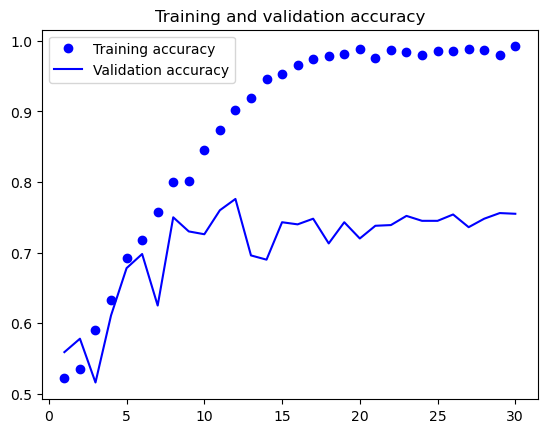

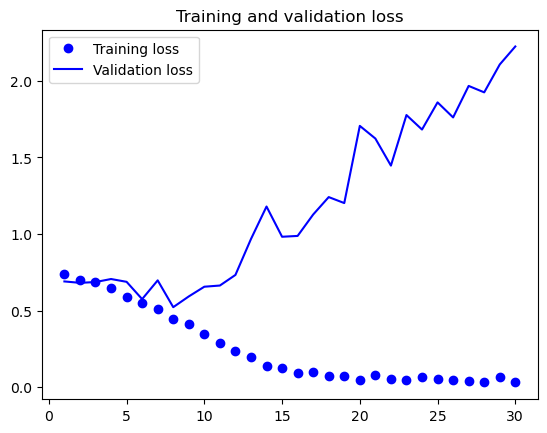

In [18]:
import matplotlib.pyplot as plt

# 绘制精度曲线
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

# 绘制损失曲线
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### 在测试集评估模型

In [19]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 12s 176ms/step - loss: 0.5872 - accuracy: 0.7310
Test accuracy: 0.731


## 使用数据增强

过拟合的原因在于学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，模型能够观察到数据分布的所有内容，那么永远不会出现过拟合。<p>

**数据增强**是指从现有的训练样本中生成更多的训练数据，做法是利用一些能够生成可信图像的随机变换来**增强**（augment）样本。<p>

**数据增强的目的**，模型在训练时不会两次查看完全相同的图片。这有助于模型观察到数据的更多内容，从而具有更强的泛化能力。<p>

Keras中在模型构建一开始为模型添加一些**数据增强层**。

### Keras定义一个数据增强代码

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

`RandomFlip("horizontal")`：将水平翻转应用于随机抽取的50%的图像。 <p>

`RandomRotation(0.1)`：将输入图像在 [-10%, +10%]的范围随机旋转（这个范围是相对于整个圆的比例，用角度表示的话，范围是[-36°, +36°]）。<p>

`RandomZoom(0.2)`：放大或缩小图像，缩放比例在[-20%, +20%]范围内随机取值。

2024-09-29 11:06:20.634397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


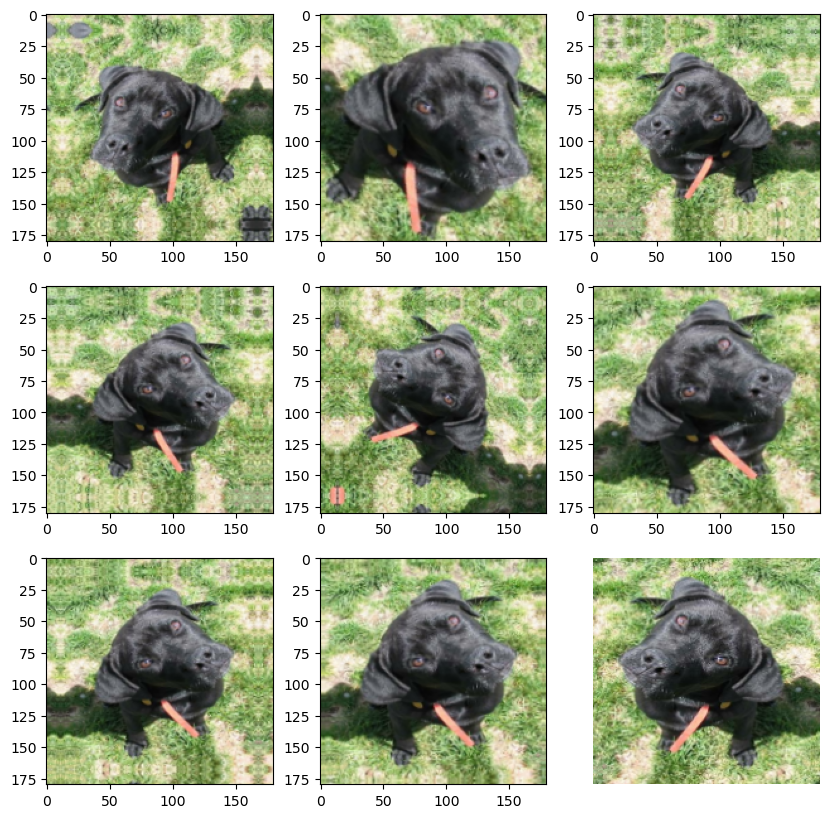

In [21]:
import matplotlib.pyplot as plt
# 随机显示几张增强后的训练图像
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")

### 定义包含数据增强和dropout的新卷积神经网络

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
# 定义数据增强
x = data_augmentation(inputs)

x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

### 训练一个正则化的卷积神经网络

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100


2024-09-29 11:06:29.357739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.4677 - loss: 0.7501 - val_accuracy: 0.5030 - val_loss: 0.6927
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.5087 - loss: 0.7012 - val_accuracy: 0.5000 - val_loss: 0.7049
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.5384 - loss: 0.6938 - val_accuracy: 0.5330 - val_loss: 0.6873
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.5700 - loss: 0.6854 - val_accuracy: 0.5430 - val_loss: 0.7007
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.5890 - loss: 0.6865 - val_accuracy: 0.5310 - val_loss: 0.7914
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.6277 - loss: 0.6600 - val_accuracy: 0.6330 - val_loss: 0.6257
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6494 - loss: 0.6229 - val_accuracy: 0.6640 - val_loss: 0.6164
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6895 - loss: 0.6009 - val_accuracy: 0.6870 - v

### 绘制精度曲线和损失曲线

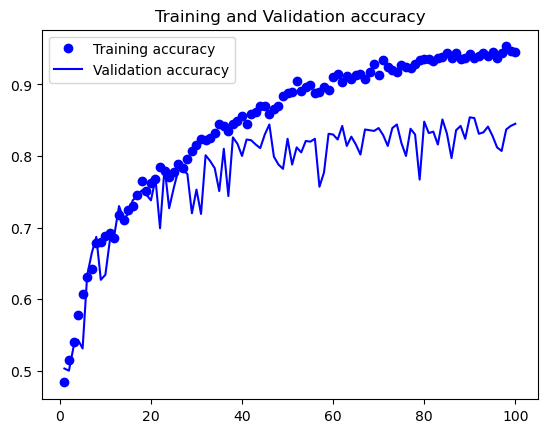

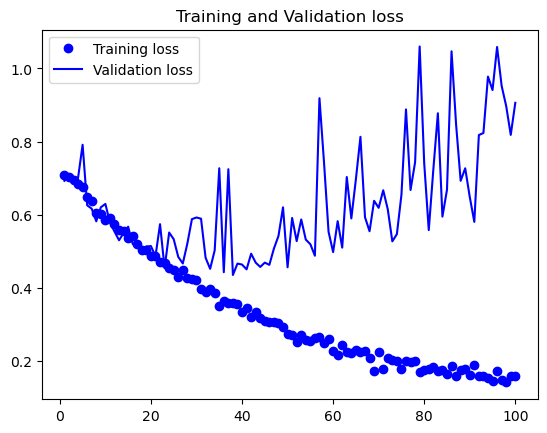

In [27]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

### 在测试集上评估模型

In [1]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

NameError: name 'keras' is not defined

# 使用预训练模型

在小型图像数据集上做深度学习，一种常用且非常有效的方法是使用预训练模型。**预训练模型**（pretrained model）是指之前在大型数据集（通常是大规模图像分类任务）上训练好的模型。与许多早期浅层学习方法相比，这种学到的特征在不同问题之间的可移植性是深度学习的重要优势，它使得深度学习对数据量很小的问题非常有效。 <p>

本例中，将使用在ImageNet数据集上训练好的大型卷积神经网络。使用**VGG16架构**。 <p>

使用预训练模型有两种方法：
- **特征提取**
- **微调模型**

## 使用预训练模型做特征提取

**特征提取：** 是指，利用之前训练好的模型学到的表示，从新样本中提取出有趣的特征，然后将这些特征输入一个新的分类器，从头开始训练这个分类器。 <p>

用于图像分类的卷积神经网络分为两部分：
1. 首先是一系列汇聚层和卷积层；
2. 然后是一个密集连接分类器。 <p>

第一部分叫作模型的**卷积基**(convolutional base)。对于卷积神经网络而言，特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上训练一个新的分类器。<p>

![预训练模型提取特征](images/预训练模型提取特征.png) <p>

**注意：** 某个卷积层提取的表示的通用性（以及可复用性）取决于该层在模型中的深度。模型中较早添加的层提取的是局部、高度通用的特征图（比如：视觉边缘、颜色和纹理），而较晚添加的层提取的是更加抽象的概念（比如：“猫耳朵”或“狗眼睛”）。因此，如果新数据集与原始模型的训练数据集有很大差异，那么最好只使用原始模型的前几层来做特征提取，而不是使用整个卷积基。 <p>

若使用的预训练模型内置于Keras中，可以从`keras.applications`模块中导入。

### 将预训练模型VGG16卷积基实例化

In [31]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58889256/58889256 [==============================] - 40s 1us/step


#### 参数解析

**参数解析：** 
- weights参数：指定模型初始化的权重检查点。
- include_top参数：指定是否包含参数连接分类器。默认情况下(include_top=True)，这个密集连接分类器对应ImageNet的1000个类别。由于我们打算使用自定义的密集连接器(只有cat和dog两个类别)，因此参数值为False。
- input_shape参数：是输入模型的图像张量的形状。这个参数是可选的。如果不传入这个参数，那么模型能够处理任意形状的输入。

#### 查看VGG16卷积基架构

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### 自定义密集连接层提取特征

自定义密集连接层提取特征有以下两种方法：
- 在新数据集上运行卷积基，将输出保存为Numpy数组，并保存在硬盘上，然后将这个数据输入到一个独立的密集连接分类器中。
    - 优点：速度快，计算代价低。因为对于每张输入图像只需运行一次卷积基，而卷积基是当前流程中计算代价最高的。
    - 缺点：无法使用数据增强。
- 在已有模型(conv_base)上添加Dense层，并在输入数据上端到端地运行整个模型。
    - 优点：可以使用数据增强。
    - 缺点：计算代价比第一种高很多

#### 不使用数据增加的快速特征提取

将conv_base在数据上的输出保存下来，然后将这些输出作为新模型的输入。在训练集、验证集和测试集上调用conv_base模型的`predict()`方法，将特征提取为Numpy数组。

##### 提取VGG16的特征和对应的标签

In [33]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

# 提取特征形状为(samples, 5, 5, 512)
print(train_features.shape)

1/1 [==============================] - 1s 1s/step
(2000, 5, 5, 512)


**注意：** `predict()`只接收图像作为输入，不接收标签，但当前数据集生成的批量既包含图像又包含标签。此外，VGG16模型的输入需要先试用函数`keras.applications.vgg16.preprocess_input`进行预处理。这个函数的作用是将像素值缩放到合适的范围内。

##### 定义并训练密集连接分类器

定义密集连接分类器（注意使用dropout正则化），并在刚刚保存的数据和标签上训练这个分类器。

In [34]:
# 设置模型输入
inputs = keras.Input(shape=(5, 5, 512))
# 构建模型网络
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
# 设置模型输出
outputs = layers.Dense(1, activation="sigmoid")(x)

# 实例化新模型
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

# 训练模型
history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 13ms/step - loss: 21.7743 - accuracy: 0.9195 - val_loss: 5.1742 - val_accuracy: 0.9650
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 4.4894 - accuracy: 0.9740 - val_loss: 5.1212 - val_accuracy: 0.9640
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 2.1995 - accuracy: 0.9830 - val_loss: 4.5855 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.5774 - accuracy: 0.9915 - val_loss: 4.0286 - val_accuracy: 0.9760
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.3434 - accuracy: 0.9940 - val_loss: 9.1798 - val_accuracy: 0.9560
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1.6066 - accuracy: 0.9895 - val_loss: 4.1580 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 0.3774 - accuracy: 0.9965 - val_loss: 5.3260 - val_accuracy: 0.9720
Epoch 8/20
63/63

##### 绘制使用简单特征提取后的精度曲线和损失曲线

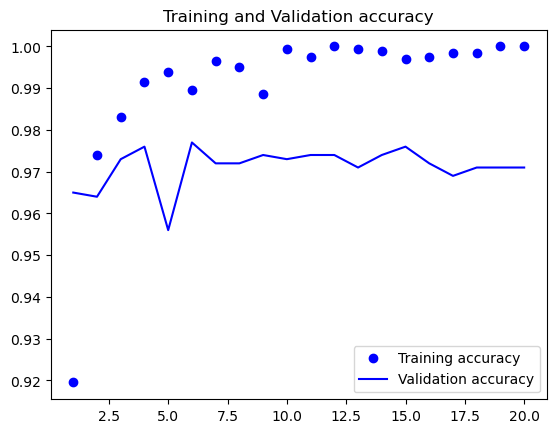

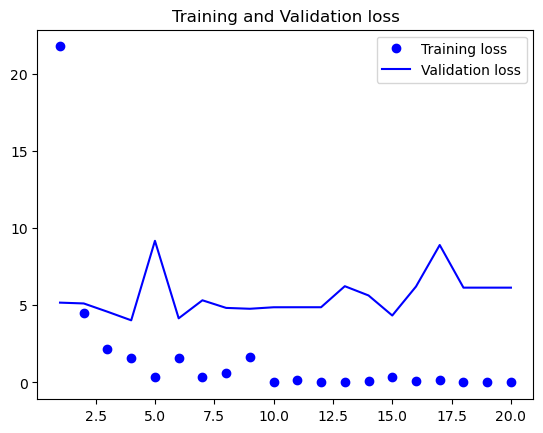

In [35]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

#### 使用数据增强的特征提取

特征提取的第二种方法。速度更慢，计算代价更高，但在训练过程中可以使用数据增强。将conv_base与一个新的密集分类器连接起来以创建一个新模型，然后在输入数据上端到端地训练这个模型。 <p>
为了实现这种方法，首先要**冻结卷积基**。冻结一层还是多层，是指在训练过程中保持其权重不变。如果不这样做，那么卷积基之前学到的表示将会在训练过程中被修改。因为其上添加的Dense层是随机初始化的，所以在神经网络中传播的权重更新将非常大，会对之前学到的表示造成很大破坏。

##### 将VGG16卷积基实例化并冻结

In [36]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

##### 打印冻结前后的可训练权重列表

In [37]:
conv_base.trainable = True
print("冻结前的可训练权重列表:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("冻结后的可训练权重列表:", len(conv_base.trainable_weights))

冻结前的可训练权重列表: 26
冻结后的可训练权重列表: 0


##### 创建新模型的三个步骤

- 一个数据增强代码块
- 已冻结的卷积基
- 一个密集连接分类器

##### 创建新模型

In [38]:
# 创建一个数据增强代码块
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
# 使用数据增强
x = data_augmentation(inputs)
# 对输入值进行缩放
x = keras.applications.vgg16.preprocess_input(x)
# 加载已冻结的卷积基
x = conv_base(x)
# 自定义密集连接分类器
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50
63/63 [==============================] - 304s 5s/step - loss: 16.3986 - accuracy: 0.9000 - val_loss: 4.9429 - val_accuracy: 0.9660
Epoch 2/50
63/63 [==============================] - 286s 5s/step - loss: 8.5732 - accuracy: 0.9365 - val_loss: 4.3988 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 286s 5s/step - loss: 4.8915 - accuracy: 0.9580 - val_loss: 4.4426 - val_accuracy: 0.9790
Epoch 4/50
63/63 [==============================] - 286s 5s/step - loss: 3.4823 - accuracy: 0.9685 - val_loss: 6.6555 - val_accuracy: 0.9660
Epoch 5/50
63/63 [==============================] - 285s 5s/step - loss: 3.6888 - accuracy: 0.9705 - val_loss: 4.5102 - val_accuracy: 0.9750
Epoch 6/50
63/63 [==============================] - 285s 5s/step - loss: 3.3167 - accuracy: 0.9700 - val_loss: 4.9986 - val_accuracy: 0.9760
Epoch 7/50
39/63 [=================>............] - ETA: 1:18 - loss: 3.0420 - accuracy: 0.9696

KeyboardInterrupt: 

## 微调预训练模型

另一种常用的模型复用方法是**微调**，它与特征提取互为补充。微调：是指对于用于特征提取的已冻结模型机，将其顶部几层“解冻”，并对这解冻的几层与新增加的部分共同训练。

### 微调的步骤

1. 在已经训练好的基网络（base network）上添加自定义网络。
2. 冻结基网络。
3. 训练新添加的部分。
4. 解冻基网络的一些层。
5. 共同训练解冻的这些层和新添加的部分。

### 解冻基网络的一些层

In [39]:
# 解冻
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### 微调模型

In [41]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine-tuning.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
12/63 [====>.........................] - ETA: 3:19 - loss: 1.3682 - accuracy: 0.9818

KeyboardInterrupt: 